<a href="https://www.quantrocket.com"><img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png"></a>

© Copyright Quantopian Inc.<br>
© Modifications Copyright QuantRocket LLC<br>
Licensed under the [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/legalcode).<br>
<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

***
[Quant Finance Lectures (adapted Quantopian Lectures)](Introduction.ipynb) › Lecture 40 - VaR and CVaR
***

# Portfolio Value at Risk and Conditional Value at Risk

By Jonathan Larkin and Delaney Granizo-Mackenzie

Value at Risk (VaR) is a key concept in portfolio risk management. It uses the past observed distribution of portfolio returns to estimate what your future losses might be at different likelihood levels. Let's demonstrate this concept through an example.

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm

import matplotlib.pyplot as plt

## Simulated Data Example

Let's simulate some returns of 10 hypothetical assets.

**NOTE**

We use normal distributions to simulate the returns, in practice real returns will almost never follow normal distributions and usually have weird behavior including fat tails. We'll discuss this more later.

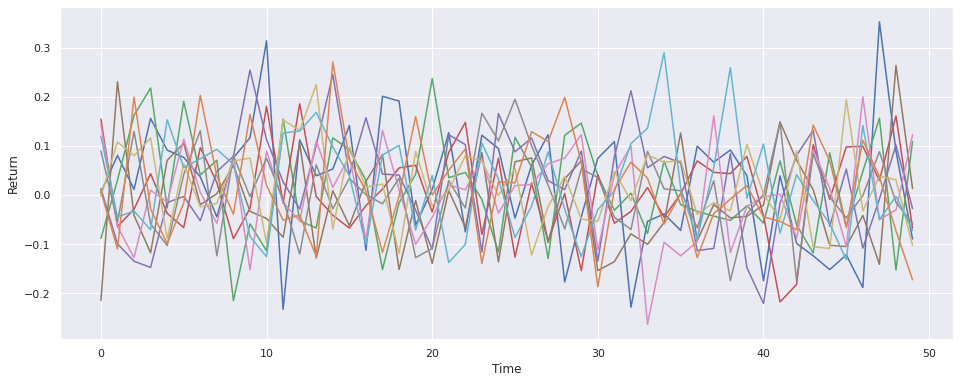

In [2]:
# mu = 0.01, std = 0.10, 1000 bars, 10 assets
mu = 0.01
sigma = 0.10
bars = 1000
num_assets = 10

returns = np.random.normal(mu, sigma, (bars, num_assets))

# Fake asset names
names = ['Asset %s' %i  for i in range(num_assets)]

# Put in a pandas dataframe
returns = pd.DataFrame(returns, columns=names)

# Plot the last 50 bars
plt.plot(returns.head(50))
plt.xlabel('Time')
plt.ylabel('Return');

The Value at Risk (VaR) for coverage $\alpha$ is defined as the maximum amount we could expect to lose with likelihood $p = 1 - \alpha$. Put another way, on no more than $100 \times p \%$ of days should we expect to lose more than the VaR. There are many ways to estimate VaR and none of them are perfect. In fact you should not put complete trust in VaR, it is rather intended as a way to get a sense of how much might be lost in different levels of extreme scenarios, and provide this info to people responsible for risk management.

VaR for a high $\alpha$ is a measure of worst case outcomes. For example one might track their $\alpha = 0.999$ VaR to understand how a 1/1000 crisis event might affect them. Because real distributions tend to diverge and become less and less consistent the further along the tail we go, extreme VaR should be taken with a grain of salt.

## Relationship to Confidence Intervals

For those familiar with confidence intervals, VaR is very similar. The idea of trying to cover a set of possible values with an interval specified by $\alpha$ is similar to how VaR tries to cover a set of possible losses. For those unfamiliar see the lecture on Confidence Intervals.

## Historical (Non-Parametric) VaR

We'll use historical VaR, which looks at previous returns distributions and uses that to compute the $p$ percentile. This percentile is the amount of loss you could reasonably expect to experience with probability $p$, assuming future returns are close to past returns. Again, this isn't perfect, and requires that there is no regime change in which the returns distribution changes. For instance, if your historical window doesn't include any crisis events, your VaR estimate will be far lower than it should be.

To compute historical VaR for coverage $\alpha$ we simply take the $100 \times (1 - \alpha)$ percentile of lowest oberserved returns and multiply that by our total value invested.

Now let's compute the VaR of this set of 10 assets. To do this we need a set of portfolio weights. We'll start super simple.

In [3]:
weights = np.ones((10, 1))
# Normalize
weights = weights / np.sum(weights)

In [4]:
def value_at_risk(value_invested, returns, weights, alpha=0.95, lookback_days=520):
    returns = returns.fillna(0.0)
    # Multiply asset returns by weights to get one weighted portfolio return
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    # Compute the correct percentile loss and multiply by value invested
    return np.percentile(portfolio_returns, 100 * (1-alpha)) * value_invested

We'll compute the VaR for $\alpha = 0.95$.

In [5]:
value_invested = 1000000

value_at_risk(value_invested, returns, weights, alpha=0.95)

-41724.851116515936

Interpreting this, we say that historically no more than $5\%$ of days resulted in losses more extreme than this, or that on each day your probability of losing this much is less than $5\%$. Keeping in mind that any forecast like this is just an estimate.

## Normal vs. Non-Parametric Historical VaR

### Normal Case

A special case of VaR is when you assume that the returns follow a given distribution rather than non-parametrically estimating it historically. In this case a normal VaR would fit our data, because all our returns were simulated form a normal distribution. We can check this by using a normal distribution Cumulative Distribution Function (CDF), which sums the area under a normal curve to figure out how likely certain values are. We'll use an inverse CDF, or PPF, which for a given likelihood will tell us to which value that likelihood corresponds.

Specifically, the closed form formula for Normal VaR is

$$VaR_{\alpha}(x) = \mu - \sigma N^{-1}(\alpha)$$

In [6]:
# Portfolio mean return is unchanged, but std has to be recomputed
# This is because independent variances sum, but std is sqrt of variance
portfolio_std = np.sqrt( np.power(sigma, 2) * num_assets ) / num_assets

# manually 
(mu - portfolio_std * norm.ppf(0.95)) * value_invested

-42014.83878755574

Seems close enough to within some random variance. Let's visualize the continuous normal case. Notice that the VaR is expressed as a return rather than an absolute loss. To get absolute loss we just need to multiply by value invested.

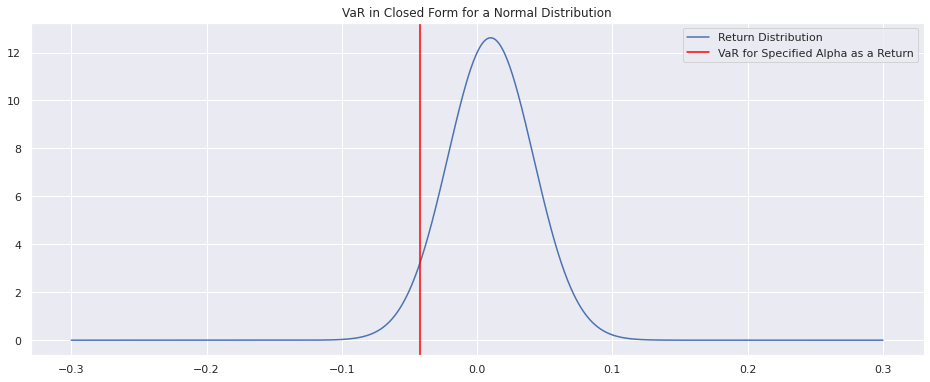

In [7]:
def value_at_risk_N(mu=0, sigma=1.0, alpha=0.95):
    return mu - sigma*norm.ppf(alpha)


x = np.linspace(-3*sigma,3*sigma,1000)
y = norm.pdf(x, loc=mu, scale=portfolio_std)
plt.plot(x,y);
plt.axvline(value_at_risk_N(mu = 0.01, sigma = portfolio_std, alpha=0.95), color='red', linestyle='solid');
plt.legend(['Return Distribution', 'VaR for Specified Alpha as a Return'])
plt.title('VaR in Closed Form for a Normal Distribution');

### Historical (Non-Parametric) Case

Historical VaR instead uses historical data to draw a discrete Probability Density Function, or histogram, then finds the point at which only $100 \times (1-\alpha)\%$ of the points are below that return. It returns that return as the VaR return for coverage $\alpha$.

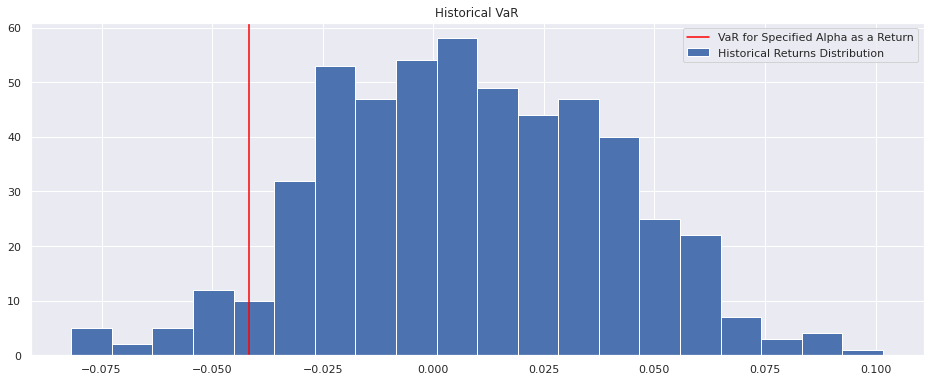

In [8]:
lookback_days = 520
alpha = 0.95

# Multiply asset returns by weights to get one weighted portfolio return
portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_VaR_return = portfolio_VaR / value_invested

plt.hist(portfolio_returns.values, bins=20)
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid');
plt.legend(['VaR for Specified Alpha as a Return', 'Historical Returns Distribution'])
plt.title('Historical VaR');

## Underlying Distributions Are Not Always Normal

In real financial data the underlying distributions are rarely normal. This is why we prefer historical VaR as opposed to an assumption of an underlying distribution. Historical VaR is also non-parametric, so we aren't at risk of overfitting distribution parameters to some data set.

### Real Data Example

We'll show this on some real financial data.

In [9]:
from quantrocket.master import get_securities
from quantrocket import get_prices

symbols = ['MMM','T','ABT','ACN','ALL','GOOGL', 'MO','AMZN','AXP','AIG','AMGN','AAPL','BAC',
       'BRK.B','BIIB','BLK','BA','BMY','CVS','COF','CAT','CELG','CVX','CSCO','C','KO','CL','CMCSA',
       'COP','DHR','DOW','DUK','DD','EMC','EMR','EXC','XOM','FDX','F','GD','GE','GILD',
       'GS','HAL','HD','HON','INTC','IBM','JPM','JNJ','KMI','LLY','LMT','LOW','MA','MCD','MDT','MRK',
       'MET','MSFT','MON','MS','NKE','NEE','OXY','ORCL','PEP','PFE','PM','PG','QCOM',
       'RTN','SLB','SPG','SO','SBUX','TGT','TXN','BK','BKNG','TWX','USB','UNP','UPS','RTX',
       'UNH','VZ','V','WMT','DIS','WFC']

securities = get_securities(symbols=symbols, vendors='usstock')

In [10]:
data = get_prices(
    'usstock-learn-1d', 
    data_frequency='daily', 
    sids=securities.index.tolist(),
    fields='Close', 
    start_date='2009-01-01', 
    end_date='2011-04-04').loc['Close']

num_stocks = len(data.columns)

In [11]:
returns = data.pct_change()
returns = returns - returns.mean(skipna=True) # de-mean the returns

Now we need to generate some weights.

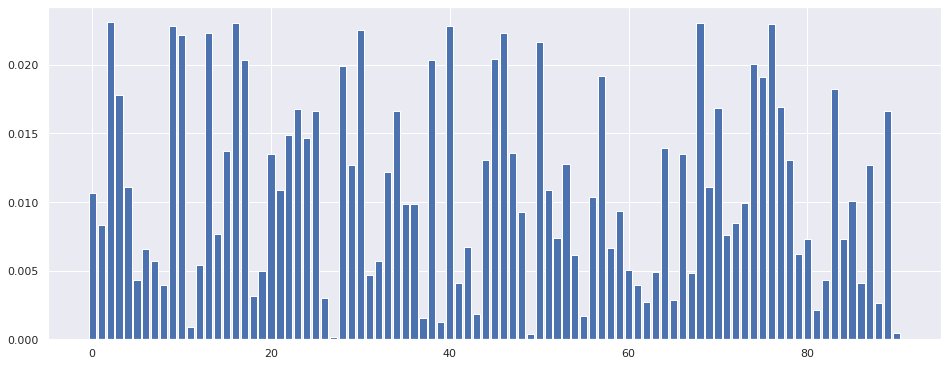

In [12]:
def scale(x):
    return x / np.sum(np.abs(x))

weights = scale(np.random.random(num_stocks))
plt.bar(np.arange(num_stocks), weights);

Now let's compute the VaR for $\alpha = 0.95$. We'll write this as $VaR_{\alpha=0.95}$ from now on.

In [13]:
value_at_risk(value_invested, returns, weights, alpha=0.95, lookback_days=520)

-22369.410441005184

Let's visualize this.

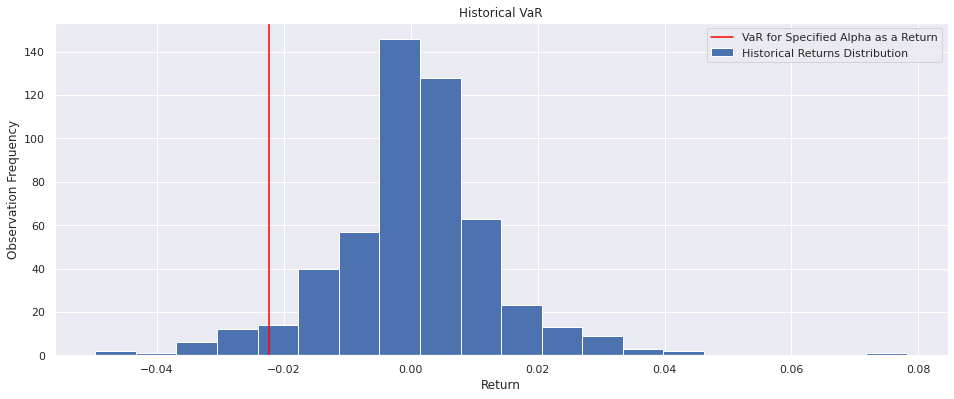

In [14]:
lookback_days = 520
alpha = 0.95

# Multiply asset returns by weights to get one weighted portfolio return
portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_VaR_return = portfolio_VaR / value_invested

plt.hist(portfolio_returns, bins=20)
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid');
plt.legend(['VaR for Specified Alpha as a Return', 'Historical Returns Distribution'])
plt.title('Historical VaR');
plt.xlabel('Return');
plt.ylabel('Observation Frequency');

The distribution looks visibly non-normal, but let's confirm that the returns are non-normal using a statistical test. We'll use Jarque-Bera, and our p-value cutoff is 0.05.

In [15]:
from statsmodels.stats.stattools import jarque_bera

_, pvalue, _, _ = jarque_bera(portfolio_returns)

if pvalue > 0.05:
    print('The portfolio returns are likely normal.')
else:
    print('The portfolio returns are likely not normal.')

The portfolio returns are likely not normal.


Sure enough, they're likely not normal, so it would be a big mistake to use a normal distribution to underlie a VaR computation here.

## We Lied About 'Non-Parametric'

You'll notice the VaR computation conspicuously uses a lookback window. This is a parameter to the otherwise 'non-parametric' historical VaR. Keep in mind that because lookback window affects VaR, it's important to pick a lookback window that's long enough for the VaR to converge. To check if our value has seemingly converged let's run an experiment.

Also keep in mind that even if something has converged on a say 500 day window, that may be ignoring a financial collapse that happened 1000 days ago, and therefore is ignoring crucial data. On the other hand, using all time data may be useless for reasons of non-stationarity in returns varaince. Basically as returns variance changes over time, older measurements may reflect state that is no longer accurate. For more information on non-stationarity you can check out the lecture on "Integration, Cointegration, and Stationarity."

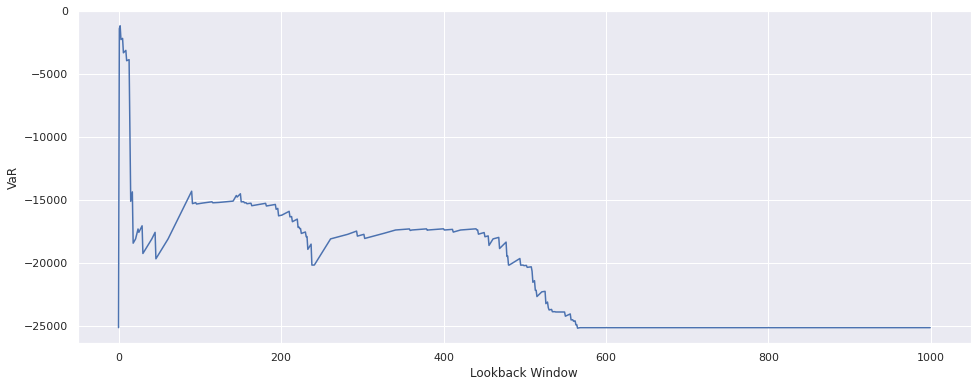

In [16]:
N = 1000
VaRs = np.zeros((N, 1))
for i in range(N):
    VaRs[i] = value_at_risk(value_invested, returns, weights, lookback_days=i)

plt.plot(VaRs)
plt.xlabel('Lookback Window')
plt.ylabel('VaR');

We can see here that VaR does appear to converge within a 400-600 lookback window period. Therefore our 520 day parameter should be fine. In fact, 1000 may be better as it uses strictly more information, but more computationally intensive and prey to stationarity concerns.

It can be useful to do analyses like this when evaluating whether a VaR is meaningful. Another check we'll do is for stationarity of the portfolio returns over this time period.

In [17]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(portfolio_returns)
pvalue = results[1]

if pvalue < 0.05:
    print('Process is likely stationary.')
else:
    print('Process is likely non-stationary.')

Process is likely stationary.


## Conditional Value at Risk (CVaR)

CVaR is what many consider an improvement on VaR, as it takes into account the shape of the returns distribution. It is also known as Expected Shortfall (ES), as it is an expectation over all the different possible losses greater than VaR and their corresponding estimated likelihoods.

If you are not familiar with expectations, much content is available online. However we will provide a brief refresher.

### Expected Value

Say you have a fair six sided die. Each number is equally likely. The notion of an expectation, written as $\mathrm{E}(X)$, is what should you expect to happen out of all the possible outcomes. To get this you multiply each event by the probability of that event and add that up, think of it as a probability weighted average. With a die we get

$$1/6 \times 1 + 1/6 \times 2 + 1/6 \times 3 + 1/6 \times 4 + 1/6 \times 5 + 1/6 \times 6 =  3.5$$

When the probabilities are unequal it gets more complicated, and when the outcomes are continuous we have to use integration in closed form equations. Here is the formula for CVaR.

$$CVaR_{\alpha}(x) \approx \frac{1}{(1-\alpha)} \int_{f(x,y) \geq VaR_{\alpha}(x)} f(x,y)p(y)dy dx$$

In [18]:
def cvar(value_invested, returns, weights, alpha=0.95, lookback_days=520):
    # Call out to our existing function
    var = value_at_risk(value_invested, returns, weights, alpha, lookback_days=lookback_days)
    returns = returns.fillna(0.0)
    portfolio_returns = returns.iloc[-lookback_days:].dot(weights)
    
    # Get back to a return rather than an absolute loss
    var_pct_loss = var / value_invested
    
    return value_invested * np.nanmean(portfolio_returns[portfolio_returns < var_pct_loss])

Let's compute CVaR on our data and see how it compares with VaR.

In [19]:
cvar(value_invested, returns, weights, lookback_days=500)

-28104.40110953897

In [20]:
value_at_risk(value_invested, returns, weights, lookback_days=500)

-20217.124826010426

CVaR is higher because it is capturing more information about the shape of the distribution, AKA the moments of the distribution. If the tails have more mass, this will capture that. In general it is considered to be a far superior metric compared with VaR and you should use it over VaR in most cases.

Let's visualize what it's capturing.

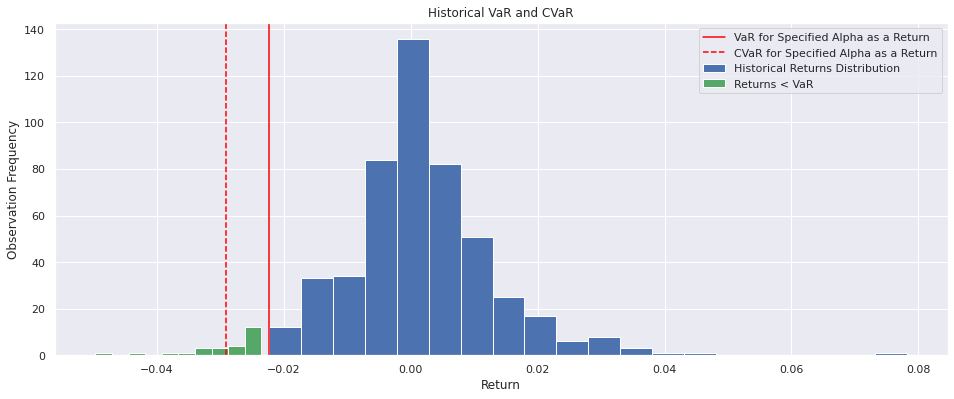

In [21]:
lookback_days = 520
alpha = 0.95

# Multiply asset returns by weights to get one weighted portfolio return
portfolio_returns = returns.fillna(0.0).iloc[-lookback_days:].dot(weights)

portfolio_VaR = value_at_risk(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_VaR_return = portfolio_VaR / value_invested

portfolio_CVaR = cvar(value_invested, returns, weights, alpha=0.95)
# Need to express it as a return rather than absolute loss
portfolio_CVaR_return = portfolio_CVaR / value_invested

# Plot only the observations > VaR on the main histogram so the plot comes out
# nicely and doesn't overlap.
plt.hist(portfolio_returns[portfolio_returns > portfolio_VaR_return], bins=20)
plt.hist(portfolio_returns[portfolio_returns < portfolio_VaR_return], bins=10)
plt.axvline(portfolio_VaR_return, color='red', linestyle='solid');
plt.axvline(portfolio_CVaR_return, color='red', linestyle='dashed');
plt.legend(['VaR for Specified Alpha as a Return',
            'CVaR for Specified Alpha as a Return',
            'Historical Returns Distribution', 
            'Returns < VaR'])
plt.title('Historical VaR and CVaR');
plt.xlabel('Return');
plt.ylabel('Observation Frequency');

### Checking for Convergence Again

Finally, we'll check for convergence.

/tmp/ipykernel_2603/1097424952.py:10: RuntimeWarning: Mean of empty slice
  return value_invested * np.nanmean(portfolio_returns[portfolio_returns < var_pct_loss])


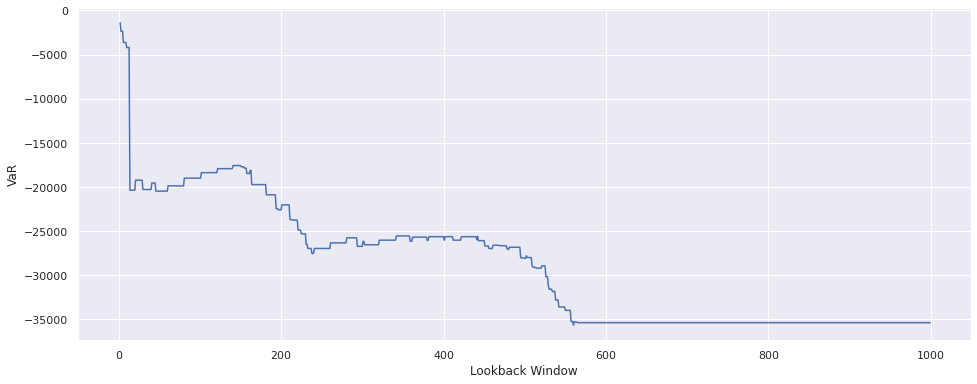

In [22]:
N = 1000
CVaRs = np.zeros((N, 1))
for i in range(N):
    CVaRs[i] = cvar(value_invested, returns, weights, lookback_days=i)

plt.plot(CVaRs)
plt.xlabel('Lookback Window')
plt.ylabel('VaR');

## Sources

 * http://www.wiley.com/WileyCDA/WileyTitle/productCd-1118445597.html
 * http://www.ise.ufl.edu/uryasev/publications/
 * http://www.ise.ufl.edu/uryasev/files/2011/11/VaR_vs_CVaR_CARISMA_conference_2010.pdf
 * http://faculty.washington.edu/ezivot/econ589/me20-1-4.pdf

---

**Next Lecture:** [Integration, Cointegration, and Stationarity](Lecture41-Integration-Cointegration-and-Stationarity.ipynb)

[Back to Introduction](Introduction.ipynb) 

---

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by QuantRocket LLC ("QuantRocket"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, the authors have not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information believed to be reliable at the time of publication. QuantRocket makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*